In [2]:
import numpy as np 
import pandas as pd 
dataset = pd.read_csv("emotion.data")

In [3]:
#dataset.emotions.value_counts().plot.bar(),

In [4]:
dataset.head(10)

,Unnamed: 0,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love
5,18231,i find myself frustrated with christians becau...,love
6,10714,i am one of those people who feels like going ...,joy
7,35177,i feel especially pleased about this as this h...,joy
8,122177,i was struggling with these awful feelings and...,joy
9,26723,i feel so enraged but helpless at the same time,anger


In [5]:
input_sentences = [text.split(" ") for text in dataset["text"].values.tolist()]
labels = dataset["emotions"].values.tolist()


In [6]:
word2id = dict()
label2id = dict()

max_words = 0 
for sentence in input_sentences:
    for word in sentence:
           if word not in word2id:
            word2id[word] = len(word2id)
    if len(sentence) > max_words:
        max_words = len(sentence)
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'surprise', 1: 'anger', 2: 'fear', 3: 'sadness', 4: 'love', 5: 'joy'}

In [7]:
import keras
X = [[word2id[word] for word in sentence] for sentence in input_sentences]
Y = [label2id[label] for label in labels]
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X, max_words)
Y = keras.utils.to_categorical(Y, num_classes=len(label2id), dtype='float32')
print("Shape of X: {}".format(X.shape))
print("Shape of Y: {}".format(Y.shape))

Using TensorFlow backend.


Shape of X: (416809, 178)
Shape of Y: (416809, 6)


In [ ]:
embedding_dim = 100 
sequence_input = keras.Input(shape=(max_words,), dtype='int32')
embedded_inputs =keras.layers.Embedding(len(word2id) + 1,embedding_dim,input_length=max_words)(sequence_input)
embedded_inputs = keras.layers.Dropout(0.2)(embedded_inputs)
lstm_outs = keras.layers.wrappers.Bidirectional(keras.layers.LSTM(embedding_dim, return_sequences=True))(embedded_inputs)
lstm_outs = keras.layers.Dropout(0.2)(lstm_outs)

input_dim = int(lstm_outs.shape[2])
permuted_inputs = keras.layers.Permute((2, 1))(lstm_outs)
attention_vector = keras.layers.TimeDistributed(keras.layers.Dense(1))(lstm_outs)
attention_vector = keras.layers.Reshape((max_words,))(attention_vector)
attention_vector = keras.layers.Activation('softmax', name='attention_vec')(attention_vector)
attention_output = keras.layers.Dot(axes=1)([lstm_outs, attention_vector])

fc = keras.layers.Dense(embedding_dim, activation='relu')(attention_output)
output = keras.layers.Dense(len(label2id), activation='softmax')(fc)
model = keras.Model(inputs=[sequence_input], outputs=output)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')
model.summary()

W0629 14:03:31.086005 4452513216 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0629 14:03:31.122311 4452513216 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0629 14:03:31.138306 4452513216 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0629 14:03:31.165135 4452513216 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0629 14:03:31.175369 4452513216 deprecati

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 178)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 178, 100)     7530300     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 178, 100)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 178, 200)     160800      dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [ ]:
model.fit(X, Y, epochs=2, batch_size=64, validation_split=0.1, shuffle=True)

W0629 14:03:31.913020 4452513216 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 375128 samples, validate on 41681 samples
Epoch 1/2
  3712/375128 [..............................] - ETA: 1:20:13 - loss: 1.5897 - acc: 0.3305

In [22]:
model_with_attentions = keras.Model(inputs=model.input,outputs=[model.output,model.get_layer('attention_vec').output])

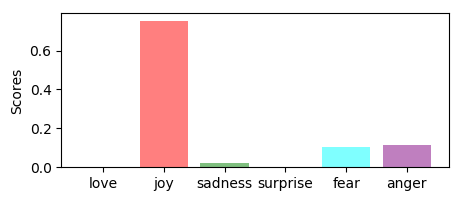

In [38]:
import random
import math

sample_text ="i am so happy today because i won"
tokenized_sample = sample_text.split(" ")
encoded_samples = [[word2id[word] for word in tokenized_sample]]
encoded_samples = keras.preprocessing.sequence.pad_sequences(encoded_samples, maxlen=max_words)
label_probs, attentions = model_with_attentions.predict(encoded_samples)
label_probs = {id2label[_id]: prob for (label, _id), prob in zip(label2id.items(),label_probs[0])}
token_attention_dic = {}
max_score = 0.0
min_score = 0.0
for token, attention_score in zip(tokenized_sample, attentions[0][-len(tokenized_sample):]):
    token_attention_dic[token] = math.sqrt(attention_score)
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)
    

html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
for token, attention in token_attention_dic.items():
    html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),token)
html_text += "</p>"

display(HTML(html_text))
emotions = [label for label, _ in label_probs.items()]
scores = [score for _, score in label_probs.items()]
plt.figure(figsize=(5,2))
plt.bar(np.arange(len(emotions)), scores, align='center', alpha=0.5, color=['black', 'red', 'green', 'blue', 'cyan', "purple"])
plt.xticks(np.arange(len(emotions)), emotions)
plt.ylabel('Scores')
plt.show()


In [27]:
model.save("model.h5")